# Functions and imports 

In [1]:
%pylab inline
from collections import Counter,deque
import heapq
import sympy,re
from sympy.abc import x
from pprint import pprint
import os,glob, operator
import time
import progressbar
from progressbar import Counter, Timer, ProgressBar, Attribute
from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


In [2]:
pylab.rcParams['figure.figsize'] = (15.0, 8.0)

In [3]:


def import_cfs(directory, filename):
    os.chdir(directory)
    d = [(f,open(f,'r')) for f in glob.glob(filename+'*')]
    cf ={}
    for (filename, f) in d:
        key = f.readline()
        if key=='':
            f.close()
            continue
        cf[key] = numpy.loadtxt(filename, skiprows=1, dtype=int)
        f.close()
    return cf

def get_maxes(cf):
    maxes={p:[] for p in cf}
    prevMax = {p:0 for p in cf}
    for p in cf:
        for c in cf[p]:
            prevMax[p] = max(c, prevMax[p])
            maxes[p].append(prevMax[p])
    return maxes

def get_means(cf):
    means = {}
    for c in cf:
        ms = numpy.cumsum(cf[c])
        for i in range(1,len(cf[c])+1):
            ms[i-1] = ms[i-1]/i
        means[c] = ms
    return means

def get_runningmeans(cf, var):
    return {c:np.convolve(cf[c], np.ones((var, ))/var, mode='valid') for c in cf}

def get_counts(cf):
    return {p : Counter(cf[p]) for p in cf}

def maxes_list(polys,cf):
    t=[[0 for i in range(2*len(polys))] for i in range(10)]
    m=0
    for p in polys:
        a=numpy.array(cf[p])
        ind = np.argpartition(a, -10)[-10:]
        ind=sort(ind)
        n=0
        for i in ind:
            t[n][2*m]=i
            t[n][2*m+1]=a[i]
            n+=1
        m+=1
    return t

def sympy_poly(p):
    p =re.sub("[^0-9\-]", ",",p).split(",")
    coeffs = [int(c) for c in p if c!='']
    counter = 0
    y = sympy.poly(0,x)
    for c in coeffs:
        y += sympy.poly(c*x**counter, x)
        counter +=1
    return y

def latex_poly(p):
    return sympy.latex(p.as_expr(), mode='inline')

def disc_poly(p):
    return sympy.discriminant(p)

def plot_stuff(data):
    fig = pyplot.figure()
    ax = fig.add_subplot(111)
    pyplot.rc('text', usetex=True)
    pyplot.rc('font', family='serif')
    plots= []
    for p in data:
        sp = sympy_poly(p)
        ax.plot(data[p], label=latex_poly(sp)+" "+str(disc_poly(sp)))
    pyplot.legend(loc='upper right');
    return fig, ax

def print_polys(polys):
    for c in polys:
        p = sympy_poly(c)
        print(latex_poly(p)+' & '+str(disc_poly(p))  + ' \\\\')
        
def create_lists(polys, sep):
    discs = {c:disc_poly(sympy_poly(c)) for c in polys}
    sorted_discs = sorted(discs.items(), key=operator.itemgetter(1))
    d = deque(sorted_discs)
    result = []
    while len(d)>0:
        r = []
        for j in range(sep):
            if len(d)>0:
                r.append(d.popleft()[0])
            else:
                break
        result.append(r)
    return result
    
def most_common(polys, counts):
    n=0
    t= [[0 for i in range(len(polys))] for i in range(10)]
    for p in polys:
        for i in counts[p].most_common(10):
            t[i[0]-1][n]=i[1]*1.0/len(cf[p])
        n+=1
    return t

def export_latex_table(t,f,s):
    numpy.savetxt(s+".csv", t, delimiter=' & ', fmt=f, newline=' \\\\\n')
    
def maxes(cf):
    maxes = get_maxes(cf)
    plot_stuff(maxes)
    
def means(cf):
    means = get_means(cf)
    plot_stuff(means)
    
def runmeans(cf):
    runmeans = get_runningmeans(cf, 1000)
    plot_stuff(runmeans)
    
def print_counts(cf):
    counts = get_counts(cf)
    pprint(most_common(cf.keys(), counts))
    pprint(maxes_list(cf.keys(), cf))

In [4]:
def density_histogram(means):
    r = numpy.arange(len(means))
    plt.hist2d(r, means, (50, 50), cmap=plt.cm.jet)
    plt.colorbar()

# Import work

In [6]:
os.chdir('/shared/storage/maths/research/numbertheory/sjb577/cf/')

In [7]:
import sqlite3
from decimal import *
getcontext().prec = 10
conn = sqlite3.connect('ContinuedFractionData.db')
c = conn.cursor()

In [8]:
c.execute('create table algeNumbers(algeNumber text, algeNumberId integer)')
c.execute('create table cfs(algeNumberId integer, position integer, cf integer, mean real, max integer)')

In [9]:
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [11]:
def input_data(cursor, directory):
    os.chdir(directory)
    files = [f for f in glob.glob('*')]
    widgets = [Counter(), ' ',  Timer()]
    pbar = ProgressBar(widgets=widgets,
                       maxval=2337).start()
    count = 0
    for f in files:
        i = int(re.match(r'(.*?)(\d+$)', f).groups()[1])
        count+=1
        pbar.update(count)
        r = open(f, 'r')
        key = r.readline()
        if key=='':
            r.close()
            continue
        data = numpy.loadtxt(f, skiprows=1, dtype=int)
        c.execute("insert into algeNumbers values (?, ?)", (key, i))
        alldata=[]
        newmax = 0
        mean = 0
        s = 0
        for n in range(len(data)):
            s+=data[n]
            mean = Decimal(s/(n+1))
            if data[n]>newmax:
                newmax = data[n]
            alldata.append((i, n, data[n],float(mean), newmax))
        c.executemany("insert into cfs values (?,?,?,?,?)", alldata)
        r.close()
        clear_output()
        print("Database is "+sizeof_fmt(os.path.getsize('/shared/storage/maths/research/numbertheory/sjb577/cf/ContinuedFractionData.db')))
        conn.commit()
    pbar.finish()

In [ ]:
input_data(c, '/usr/userfs/s/sjb577/shared/cf/polys103/')

0 Elapsed Time: 0:00:00                                                        

In [ ]:
cf = import_cfs('/usr/userfs/s/sjb577/shared/cf/33polys/','polys.job.o314555.1')

# Data playing

In [7]:
lists = create_lists(cf, 10)


In [8]:
print_polys(lists[0])

$x^{3} - 10 x^{2} - 10$ & -42700 \\
$x^{3} - 9 x^{2} - 10$ & -31860 \\
$x^{3} - 10 x^{2} - 2 x - 6$ & -26700 \\
$x^{3} - 10 x^{2} - x - 6$ & -25948 \\
$x^{3} - 10 x^{2} - 6$ & -24972 \\
$x^{3} - 10 x^{2} + x - 6$ & -23796 \\
$x^{3} - 8 x^{2} - 10$ & -23180 \\
$x^{3} - 10 x^{2} + 2 x - 6$ & -22444 \\
$x^{3} - 10 x^{2} + 3 x - 6$ & -20940 \\
$x^{3} - 9 x^{2} - 3 x - 6$ & -20547 \\


AttributeError: The dimension of bins must be equal to the dimension of the  sample x.

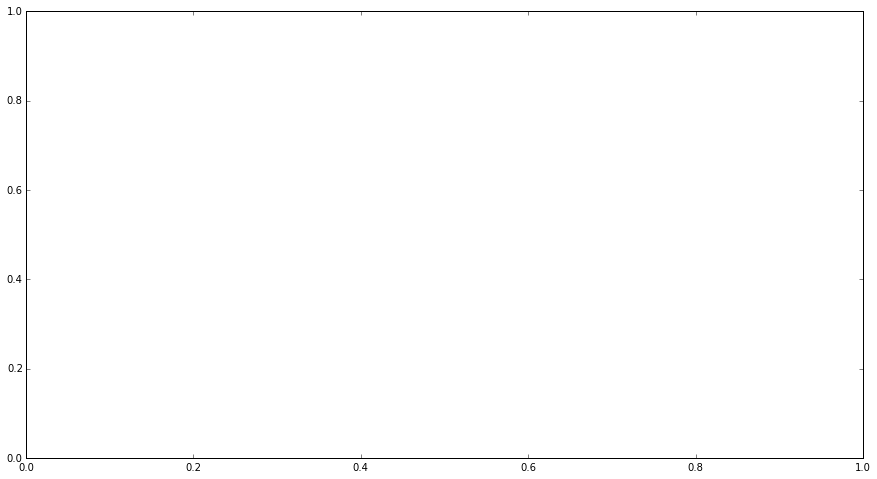

In [9]:
cfs = {k:v for (k,v) in cf.items() if k in lists[0]}
ms = get_means(cfs)
means =[]
for x in ms:
    means = numpy.concatenate((means, ms[x]))
r = numpy.arange(len(means))
plt.hist2d(r,means, (500, 500), cmap=plt.cm.jet)
plt.colorbar()

In [18]:
ms[cfs.keys()[0]]

array([10, 13,  9, ..., 18, 18, 18])

<matplotlib.colorbar.Colorbar instance at 0x7ff4bf24e560>

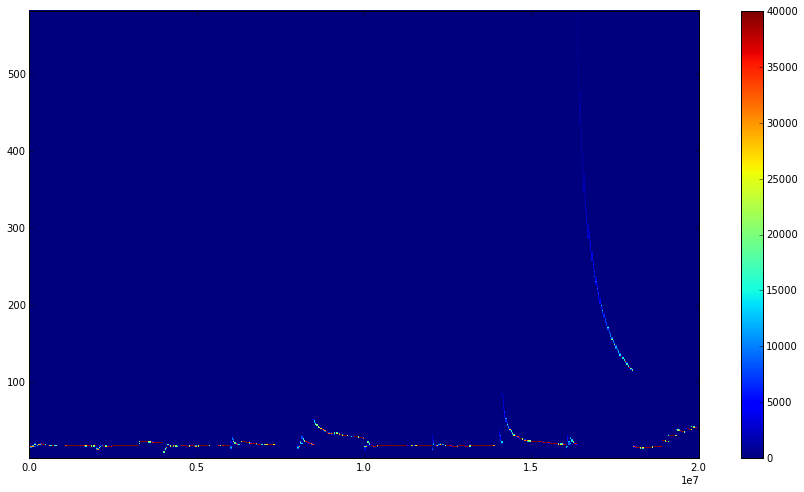

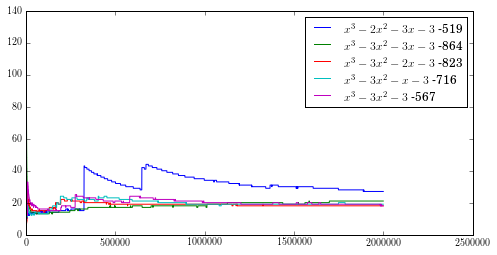

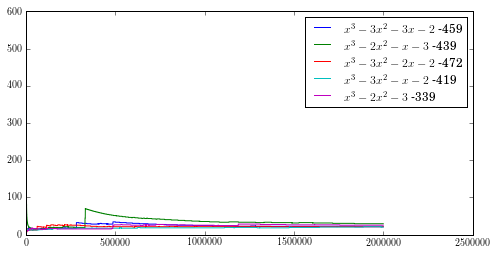

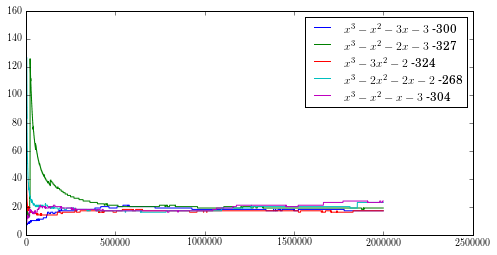

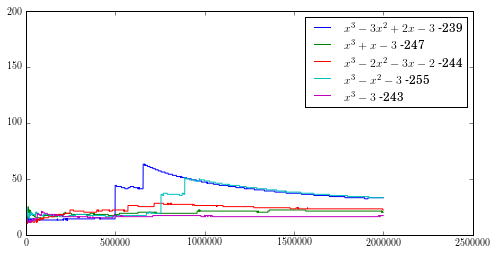

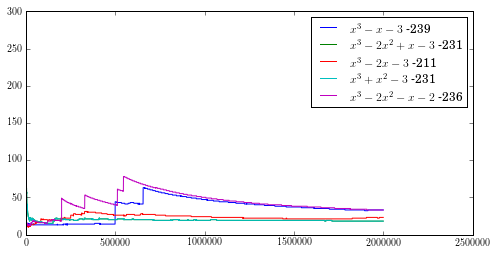

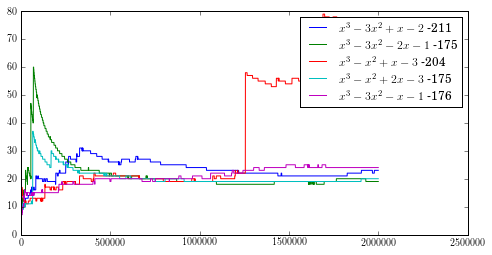

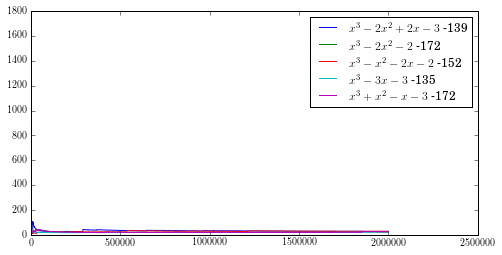

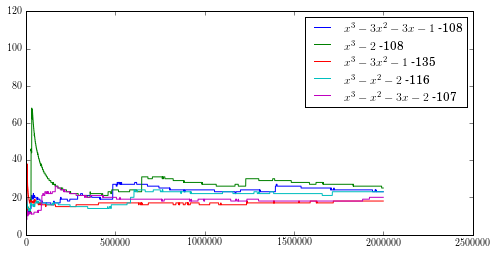

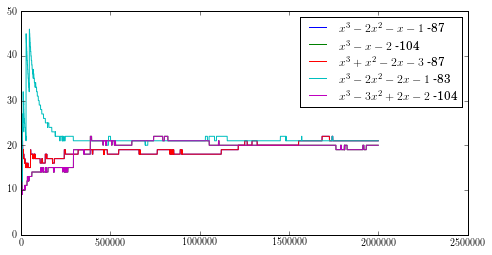

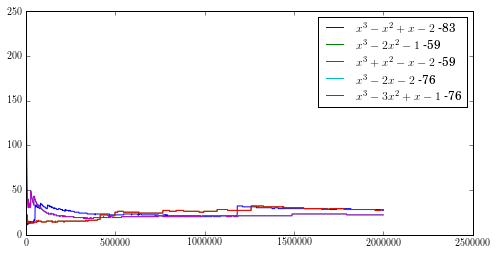

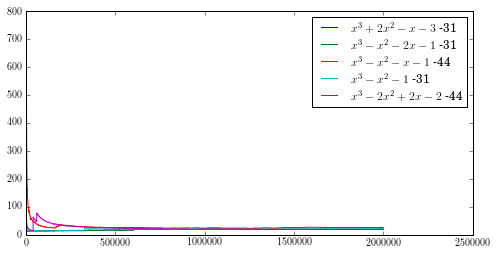

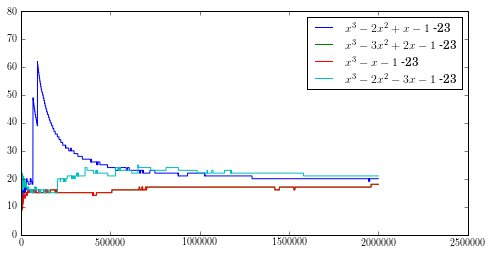

In [30]:

for l in lists:
    cfs = {k:v for (k,v) in cf.items() if k in l}
    ms = get_means(cfs)
    plot_stuff(ms)

In [ ]:
maxes(cf)
savefig('maxes.pdf')

In [ ]:
runmeans(cf)
savefig('runmeans.pdf')

$x^{3} - 3 x^{2} + 2 x - 3$ & -239 \\
$x^{3} - 3 x^{2} - 3 x - 2$ & -459 \\
$x^{3} - 2 x - 2$ & -76 \\
$x^{3} - 2 x - 3$ & -211 \\
$x^{3} - x^{2} - x - 1$ & -44 \\
$x^{3} - 3 x^{2} + x - 1$ & -76 \\
$x^{3} - 3 x^{2} - x - 2$ & -419 \\
$x^{3} - 2 x^{2} - x - 1$ & -87 \\
$x^{3} + 2 x^{2} - x - 3$ & -31 \\
$x^{3} - 3 x^{2} + 2 x - 1$ & -23 \\
$x^{3} - 2 x^{2} + 2 x - 3$ & -139 \\
$x^{3} - 2 x^{2} - 3 x - 2$ & -244 \\
$x^{3} - 2 x^{2} - 2 x - 2$ & -268 \\
$x^{3} - 2 x^{2} - 3 x - 3$ & -519 \\
$x^{3} - 2$ & -108 \\
$x^{3} - 3 x^{2} - x - 3$ & -716 \\
$x^{3} + x^{2} - 2 x - 3$ & -87 \\
$x^{3} - 2 x^{2} - 3$ & -339 \\
$x^{3} - 3 x^{2} + x - 2$ & -211 \\
$x^{3} - x^{2} - 2 x - 3$ & -327 \\
$x^{3} - 2 x^{2} - 1$ & -59 \\
$x^{3} - x^{2} - 2 x - 1$ & -31 \\
$x^{3} - x^{2} - 3 x - 3$ & -300 \\
$x^{3} - 3 x^{2} - 2 x - 3$ & -823 \\
$x^{3} - x^{2} + x - 3$ & -204 \\
$x^{3} - 2 x^{2} + 2 x - 2$ & -44 \\
$x^{3} + x - 3$ & -247 \\
$x^{3} - x - 2$ & -104 \\
$x^{3} + x^{2} - x - 2$ & -59 \\
$x^{3} - 3 x^

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]


/scratch/sjb577/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


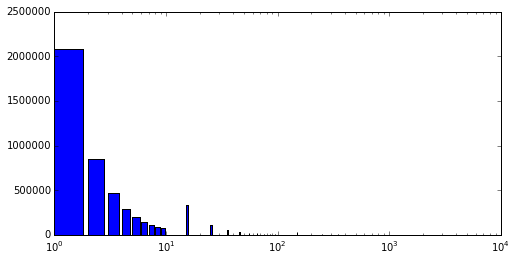

In [17]:
bins = [n*10**j for j in range(0,4) for n in range(1, 10)]
print(bins)
h, b = numpy.histogram(numpy.array(cf[allpolys[0]]), bins=bins)
fig, ax = pyplot.subplots()
center = (b[:-1] + b[1:]) / 2
ax.bar(center,h)
ax.set_xscale('log')
fig.show()
